In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import nibabel as nib
import os
import glob
import sys
import time
import siamxt

MY_UTILS_PATH = "../Modules/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
import ipt_utils
import cnn_utils
import metrics_utils

Using TensorFlow backend.


In [2]:
orig_path = "/media/roberto/DATA/LPBA40/Orig"
mask_path = "/media/roberto/DATA/LPBA40/Mask" 

masks_list = [os.path.join(mask_path,f) for f in os.listdir(mask_path) if f.endswith(".nii.gz")]
imgs_list = [os.path.join(orig_path,f) for f in os.listdir(orig_path) if f.endswith(".nii.gz")]
masks_list.sort()
imgs_list.sort()
print imgs_list[5]
print masks_list[5]


stats = np.load("../Data/ss_unet_cc347.npy")
mean = stats[0]
std = stats[1]

model_path = "../Data/ss_unet_cc_347_best.hdf5"
dice = np.zeros(40)
Bc = np.ones((3,3,3),dtype = bool)

/media/roberto/DATA/LPBA40/Orig/S06.nii.gz
/media/roberto/DATA/LPBA40/Mask/S06_mask.nii.gz


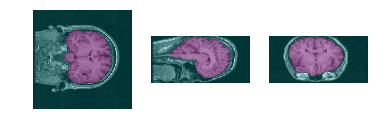

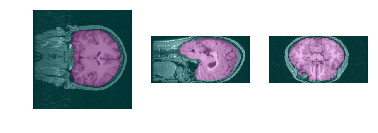

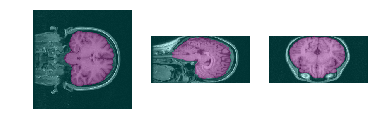

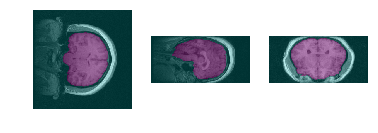

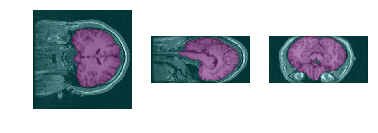

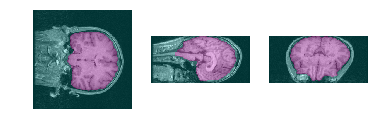

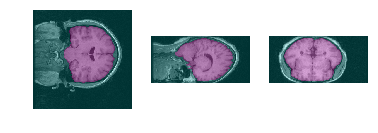

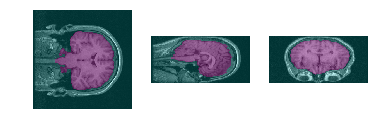

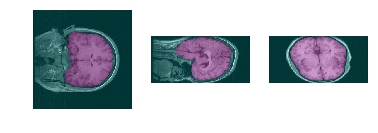

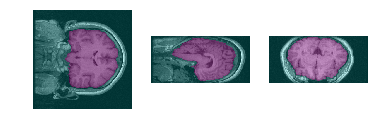

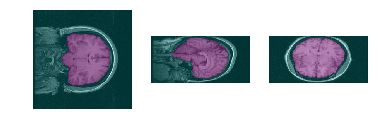

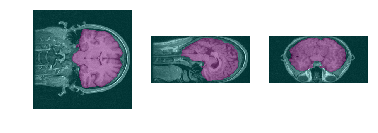

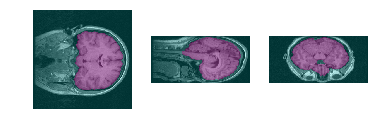

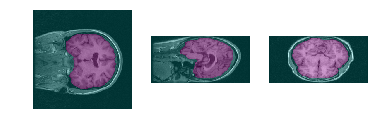

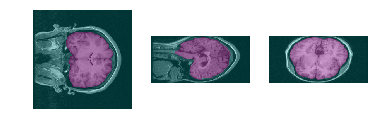

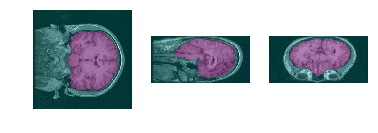

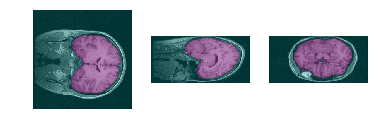

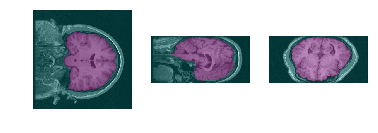

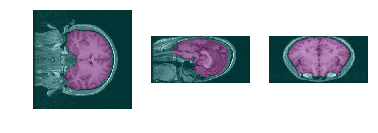

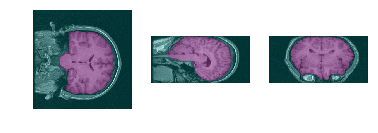

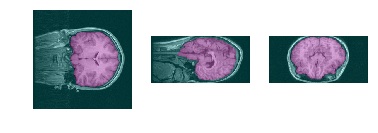

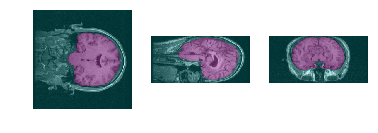

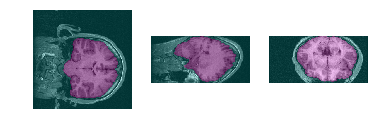

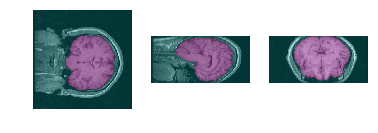

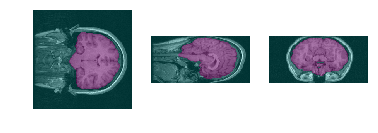

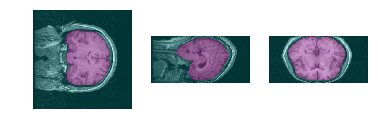

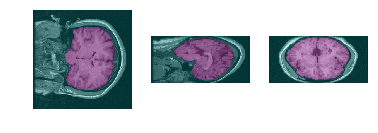

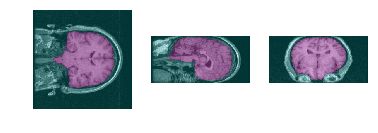

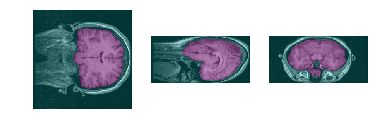

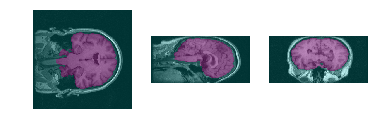

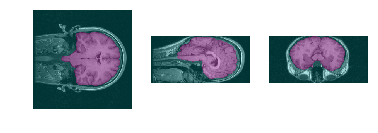

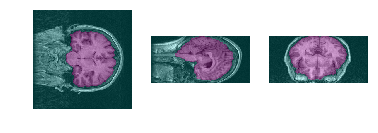

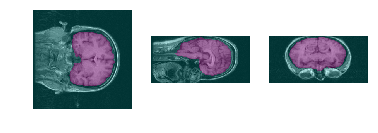

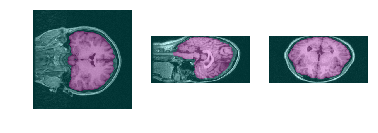

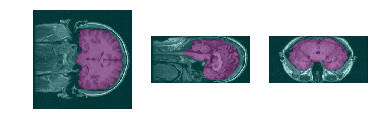

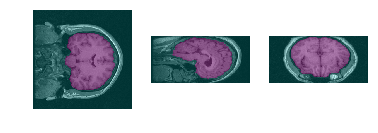

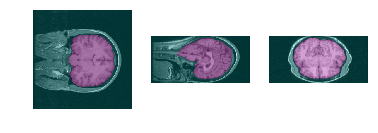

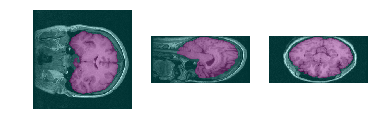

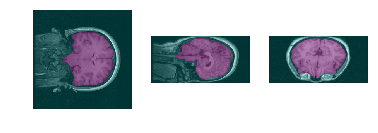

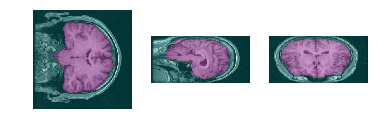

In [3]:
model = cnn_utils.get_unet_mod()
model.load_weights(model_path)
for ii in xrange(len(imgs_list)):
    img = nib.load(imgs_list[ii])
    img = img.get_data()
    img = img.transpose(1,0,2)
    img_min = img.min()
    img_max = img.max()
    img_norm = 1.0*(img - img_min)/(img_max-img_min)
    img_norm -= mean
    img_norm /= std
    x,y,z = img_norm.shape
    img_rgb = np.zeros((x-2,y,z,3))
    img_rgb[:,:,:,0] = img_norm[0:-2,:,:]
    img_rgb[:,:,:,1] = img_norm[1:-1,:,:]
    img_rgb[:,:,:,2] = img_norm[2:,:,:]
    img_rgb,nw,nz  = cnn_utils.pad_images(img_rgb)
    predict = model.predict(img_rgb)
    predict = predict[:,:-nw,:-nz,0]
    predict2 = np.zeros((x,y,z))
    predict2[1:-1,:,:] = predict
    predict2 = (predict2 >0.5).astype(np.uint8)
    mxt = siamxt.MaxTreeAlpha(predict2,Bc)
    area_max = mxt.node_array[3,1:].max() 
    mxt.areaOpen(area_max - 1)
    predict3 = mxt.getImage() > 0.5
    H,W,Z = img_norm.shape
    plt.figure()
    plt.subplot(131)
    plt.imshow(img_norm[H/2,:,:], cmap = 'gray')
    plt.imshow(predict3[H/2,:,:], cmap = 'cool',alpha = 0.2)
    plt.axis("off")
    plt.subplot(132)
    plt.imshow(img_norm[:,W/2,:], cmap = 'gray')
    plt.imshow(predict3[:,W/2,:], cmap = 'cool',alpha = 0.2)
    plt.axis("off")
    plt.subplot(133)
    plt.imshow(img_norm[:,:,Z/2], cmap = 'gray')
    plt.imshow(predict3[:,:,Z/2], cmap = 'cool',alpha = 0.2)
    plt.axis("off")
    plt.show()
    
    #ipt_utils.save_seg(predict2,affine,os.path.join("./Predict/",prefixes[ii] + "_cnn.nii.gz"))
    mask = nib.load(masks_list[ii]).get_data().transpose(1,0,2)>0.5
    dice[ii] = metrics_utils.dice(mask,predict3)  

In [4]:
print "Average dice and standrd deviation"    
print dice.mean()    
print dice.std()    

Average dice and standrd deviation
0.974369146557
0.0024023699209
